In [108]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from IPython.display import display

In [109]:
with open('../port_activity_scenario.json') as f:
    data = json.load(f)
    
machines_uses = []
for machine in data["timeseries"]:
    for use in machine["uses"]:
        machine_use = {
            "machineId": machine["machineId"],
            "machineType": machine["machineType"],
            "energyType": machine["consumption"]["energyType"],
            "consumptionPerHour": machine["consumption"]["consumptionPerHour"]
        }
        for key, value in use.items():
            machine_use[key] = value
        machines_uses.append(machine_use)

In [110]:
df = pd.DataFrame.from_dict(machines_uses)
df

,machineId,machineType,energyType,consumptionPerHour,startTs,endTs,duration,operationId,operationName,supplychainId,cargoId
0,machine_00,pompe,gazole,20,1567768395,1567780340,11945,op_0,drop,sc_5,cargo_47
1,machine_00,pompe,gazole,20,1567786071,1567794257,8186,op_1,drive,sc_2,cargo_20
2,machine_00,pompe,gazole,20,1567797229,1567807689,10460,op_2,filter,sc_5,cargo_83
3,machine_00,pompe,gazole,20,1567813248,1567825881,12633,op_3,raise,sc_2,cargo_8
4,machine_00,pompe,gazole,20,1567828379,1567841134,12755,op_4,unload,sc_6,cargo_89
...,...,...,...,...,...,...,...,...,...,...,...
917,machine_49,stacker,fuel,16,1567957502,1567969766,12264,op_917,unload,sc_9,cargo_77
918,machine_49,stacker,fuel,16,1567971512,1567986005,14493,op_918,filter,sc_8,cargo_32
919,machine_49,stacker,fuel,16,1567987601,1568005172,17571,op_919,load,sc_5,cargo_2
920,machine_49,stacker,fuel,16,1568007062,1568019483,12421,op_920,load,sc_9,cargo_84


consumptionPerHour
energyType datetime                               
diesel     2019-09-06 09:00:00                1499
           2019-09-06 10:00:00                6037
           2019-09-06 11:00:00               10127
           2019-09-06 12:00:00                9640
           2019-09-06 13:00:00               10022
...                                            ...
gazole     2019-09-09 08:00:00               10099
           2019-09-09 09:00:00                9497
           2019-09-09 10:00:00                9653
           2019-09-09 11:00:00                7894
           2019-09-09 12:00:00                3058

[308 rows x 1 columns]

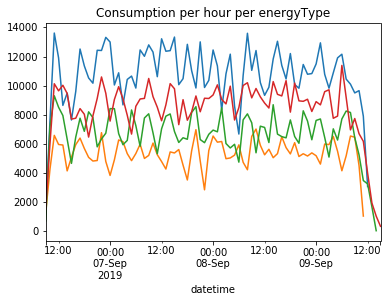

In [111]:
df["datetimes"] = df.apply(lambda row: pd.date_range(pd.to_datetime(row["startTs"], unit="s"), pd.to_datetime(row["endTs"], unit="s"), freq="1min").to_list(), axis=1)

tsdf = (df
    .set_index([elem for elem in list(df.columns) if elem != "datetimes"])["datetimes"]
    .apply(pd.Series)
    .stack()
    .reset_index()
    .drop('level_11', axis=1)
    .rename(columns={0:'datetime'})
)
tsdf['datetime'] = pd.to_datetime(tsdf['datetime'])
tsdf = tsdf.set_index('datetime')

df.drop(columns=["datetimes"])

energyTypesDf = tsdf.groupby(['energyType', pd.Grouper(freq='H')]).sum()
display(energyTypesDf[["consumptionPerHour"]])

energyTypes = list(set([row[0] for row in energyTypesDf.index]))
for energyType in energyTypes:
    energyTypesDf.loc[energyType]["consumptionPerHour"].plot(label=energyType, title="Consumption per hour per energyType")
plt.show()

,consumption
supplychainId,
sc_0,4203.584722
sc_1,3646.679722
sc_2,4274.777222
sc_3,3530.891111
sc_4,4442.277778
sc_5,3914.929167
sc_6,4318.268333
sc_7,3967.233056
sc_8,3963.940833


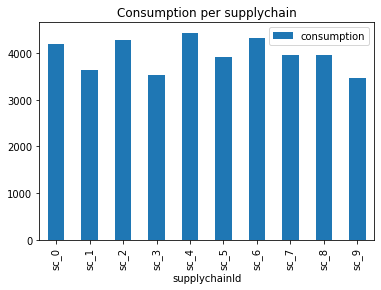

In [112]:
df["consumption"] = df.apply(lambda row: (row["duration"]/60./60)*row["consumptionPerHour"], axis=1)
consumptionDf = df.groupby(['supplychainId']).sum()[["consumption"]]
df.drop(columns=["consumption"])
display(consumptionDf)

consumptionDf.plot.bar(title="Consumption per supplychain")

,diesel,essence,fuel,gazole
supplychainId,,,,
sc_0,1107.882500,544.951389,1084.853056,1465.897778
sc_1,892.555000,766.291944,761.242222,1226.590556
sc_2,1115.303056,593.544167,705.610000,1860.320000
sc_3,814.642500,661.975556,674.756111,1379.516944
sc_4,1207.205278,713.007222,947.176667,1574.888611
sc_5,1018.232778,499.366667,897.463056,1499.866667
sc_6,1052.523056,913.202222,1168.567778,1183.975278
sc_7,1061.790833,631.057778,842.288056,1432.096389
sc_8,1593.097222,782.158611,584.593333,1004.091667


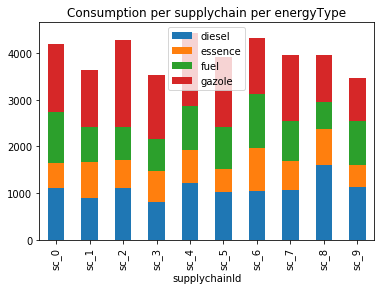

In [113]:
df["consumption"] = df.apply(lambda row: (row["duration"]/60./60)*row["consumptionPerHour"], axis=1)
consumptionDf = (
    df
    .groupby(['supplychainId', 'energyType'])
    .sum()
    [["consumption"]]
    .unstack('energyType')
)
df.drop(columns=["consumption"])
consumptionDf.columns = ['diesel', 'essence', 'fuel', 'gazole']
display(consumptionDf)

consumptionDf.plot.bar(stacked=True, title="Consumption per supplychain per energyType")


Boxplots of durations per machineType


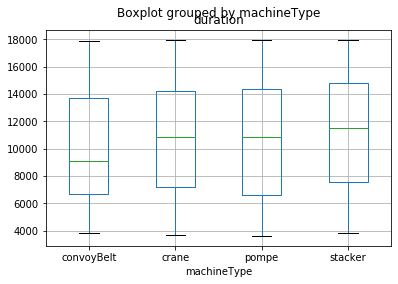

In [120]:
df.boxplot(column=["duration"], by="machineType")
print("Boxplots of durations per machineType")

In [116]:
machinesCount = (
    df
    .groupby(['machineType', 'machineId'])
    .count()
    [['startTs']]
    .rename(columns={'startTs': 'usesCount'})
)
display(machinesCount)

usesCount
machineType machineId            
convoyBelt  machine_02         21
            machine_04         21
            machine_06         21
            machine_08         19
            machine_29         18
            machine_31         19
            machine_46         20
crane       machine_03         20
            machine_05         20
            machine_14         19
            machine_16         19
            machine_18         20
            machine_28         20
            machine_32         18
            machine_35         16
            machine_36         17
            machine_37         17
            machine_38         17
            machine_39         17
            machine_44         19
pompe       machine_00         18
            machine_07         19
            machine_09         20
            machine_12         18
            machine_13         17
            machine_15         20
            machine_17         20
            machine_19         18
            machine_21         18
            machine_25         20
            machine_26         18
            machine_30         19
            machine_33         20
            machine_40         18
            machine_41         18
            machine_43         17
            machine_47         16
stacker     machine_01         18
            machine_10         18
            machine_11         18
            machine_20         17
            machine_22         17
            machine_23         18
            machine_24         17
            machine_27         18
            machine_34         18
            machine_42         19
            machine_45         17
            machine_48         17
            machine_49         18